In [59]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import flax.linen as nn
import numpy as np
import jax.numpy as jnp
import jax
import functools

In [60]:
import jax
import numpy as np
from poclaps.train.ppo import reload
from poclaps.rollout_fake_msgs import rollout_with_msgs

policy_dir = 'outputs/2024-06-14/15-39-35/'
config, pretrained_policy, env, env_params, _ = reload(policy_dir)

N_ACTIONS = env.action_space(env_params).n


def sample_obs_modelling_batch(rng,
                               noise_dim: int = 64,
                               rollout_steps: int = 500,
                               return_traj: bool = False):
    rng, rollout_rng = jax.random.split(rng)
    _, traj_batch, metrics = rollout_with_msgs(
        env, env_params, pretrained_policy,
        steps=rollout_steps,
        rng=rollout_rng
    )

    n_msgs = env_params.grid_size * env_params.grid_size
    actions = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
    msgs = jax.nn.one_hot(traj_batch.message, n_msgs)

    *batch_shape, _ = traj_batch.obs.shape
    noise = jax.random.normal(rng, (*batch_shape, noise_dim))
    inputs = (actions, msgs, noise, traj_batch.obs, traj_batch.done)
    if return_traj:
        return inputs, metrics, traj_batch
    return inputs, metrics

In [61]:
inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0), rollout_steps=5)

In [62]:
actions, msgs, noise, obs, dones = inputs
actions[:, 0].argmax(-1), msgs[:, 0].argmax(-1), dones[:, 0], obs[:, 0].reshape(-1, 2, 2, 5).argmax(-1)

(Array([1, 1, 4, 1, 1], dtype=int32),
 Array([17, 17, 17, 17, 21], dtype=int32),
 Array([False, False, False,  True,  True], dtype=bool),
 Array([[[0, 4],
         [1, 1]],
 
        [[0, 3],
         [1, 1]],
 
        [[0, 2],
         [1, 1]],
 
        [[1, 2],
         [1, 1]],
 
        [[4, 3],
         [4, 2]]], dtype=int32))

In [63]:
jax.random.uniform(jax.random.PRNGKey(0), (2, 3))

Array([[0.57450044, 0.09968603, 0.7419659 ],
       [0.8941783 , 0.59656656, 0.45325184]], dtype=float32)

In [64]:
def corrupt(rng, x, amounts):
    noise = jax.random.uniform(rng, x.shape)

    @jax.vmap
    def _corrupt(amount):
        return x * (1 - amount) + noise * amount

    return _corrupt(amounts)

In [65]:
obs.shape

(5, 4, 20)

In [66]:
N_AMOUNTS = 8
amounts = jnp.linspace(0, 1, N_AMOUNTS)
corrupted_obs = corrupt(jax.random.PRNGKey(0), obs, amounts)

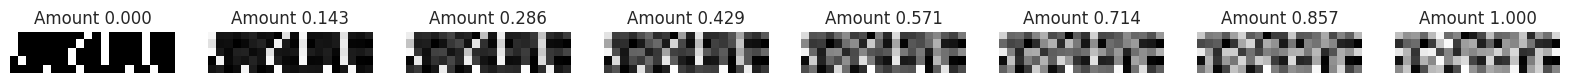

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

_, axs = plt.subplots(1, N_AMOUNTS, figsize=(20, 5))

corrupted_obs_0 = corrupted_obs[:, :, 0]

for x, ax, amount in zip(corrupted_obs_0, axs, amounts):
    ax.imshow(x, cmap='gray')
    ax.set_title(f'Amount {amount:.3f}')
    ax.axis('off') 

In [68]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
N_AMOUNTS = 8
timesteps = jnp.linspace(0, 999, N_AMOUNTS, dtype=jnp.int32)
noise = jax.random.normal(jax.random.PRNGKey(0), obs.shape)

alphas_cumprod = jnp.array(noise_scheduler.alphas_cumprod)

original_samples = jnp.repeat((obs * 2 - 1)[jnp.newaxis, ...], N_AMOUNTS, axis=0)

sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
sqrt_alpha_prod = sqrt_alpha_prod.flatten()
while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
    sqrt_alpha_prod = sqrt_alpha_prod[:, None]

sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
    sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod[:, None]

noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise

# noisy_xb = noise_scheduler.add_noise(obs, noise, timesteps)

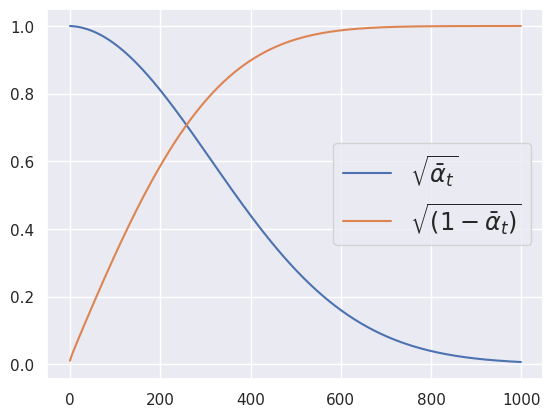

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.plot(alphas_cumprod ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - alphas_cumprod) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

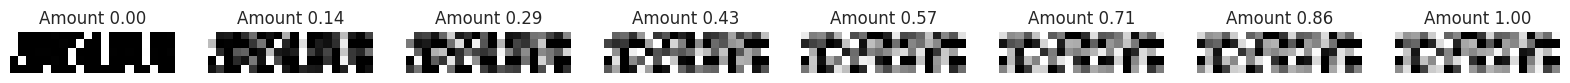

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

_, axs = plt.subplots(1, N_AMOUNTS, figsize=(20, 5))

for x, ax, amount in zip(noisy_samples[:, :, 0], axs, amounts):
    ax.imshow(x.clip(-1, 1), cmap='gray')
    ax.set_title(f'Amount {amount:.2f}')
    ax.axis('off') 

In [58]:
# (n_noise_amounts, n_timesteps, n_envs, n_obs)
noisy_samples.shape

(8, 5, 4, 20)